# Linear regression

Before using this notebook, make sure you're familiar with Pandas and NumPy.

**Regression** is a family of methods for modeling **continuous, numerical** predictions from other data.

There are various ways to characterize a regression task. For example, thinking about the **independent** inputs (`X`):

- Simple regression: there's only one independent variable.
- Multiple regression: there's more than one indepentent variable.

We can also think about the **dependent** variable (`y`):

- Univariate regression: there's only one dependent variable (target).
- Multivarite (aka multi-target or multi-output) regression: there's more than one target.

And we can think about the type of **model**:

- Linear regression: the model is linear in its _parameters_ (not necessarily its inputs), e.g. $\hat{y} = a x^2 + b x + c$.
- Nonlinear regression: the model is nonlinear in its parameters, e.g. $\hat{y} = a \mathrm{e}^{b x}$

In this notebook, we're going to consider **simple and multiple linear univariate regression**.

## Load some data

We'll use a subset of the [Rock Property Catalog](http://subsurfwiki.org/wiki/Rock_Property_Catalog) data, licensed CC BY Agile Scientific. Note that the data have been preprocessed, including the addition of noise to the density data.

In [63]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_4_lithologies_original.csv')

df

,RPC,Description,Lithology,Vp [m/s],Vs [m/s],Rho [g/cm³]
0,104818,KIAMICHI FORMA. 4,sandstone,3045.60,1595.70,2.108
1,104893,KIAMICHI REMOLD 3,sandstone,3000.60,1517.10,2.126
2,104652,NAVAJO ARCO 2,sandstone,3363.60,2041.50,2.162
3,104752,NAVAJO ARCO REMOL 1,sandstone,3195.30,1606.20,2.160
4,104598,FERRON 82-3 1677.5,sandstone,4237.50,2448.60,2.428
...,...,...,...,...,...,...
795,102178,R.PRICE 10909.5 #31,dolomite,4625.98,2759.19,2.370
796,102225,R.PRICE 10916.5 #38,dolomite,5446.19,3116.80,2.440
797,102088,R.PRICE 10883.5 #7,dolomite,5446.19,2998.69,2.570
798,102213,R.PRICE 10913.5 #35,dolomite,5347.77,2933.07,2.440


In [64]:
df.dtypes

RPC              int64
Description     object
Lithology       object
Vp [m/s]       float64
Vs [m/s]       float64
Rho [g/cm³]    float64
dtype: object

In [65]:
df = df.astype({'Lithology': 'category'})

### EXERCISE

- How many records are there?
- How many incomplete records are there? (Records with missing values.)
- How many instances of each lithology are there?
- Two of the properties are strongly correlated; which two?
- What do you notice about the Rho data?
- What do you notice about the sandstone data?

In [66]:
df.describe()

,RPC,Vp [m/s],Vs [m/s],Rho [g/cm³]
count,800.000000,800.000000,800.000000,752.000000
mean,102276.178750,3798.453532,2113.480238,2.316455
std,1537.850865,1114.387572,750.387638,0.255653
min,100031.000000,1490.711927,441.270000,1.750000
25%,101112.750000,3010.248889,1520.975000,2.117000
50%,102081.500000,3675.150000,2198.100000,2.390000
75%,103284.750000,4664.592178,2733.805000,2.530000
max,105090.000000,5993.000000,3665.000000,2.780000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   RPC          800 non-null    int64   
 1   Description  800 non-null    object  
 2   Lithology    800 non-null    category
 3   Vp [m/s]     800 non-null    float64 
 4   Vs [m/s]     800 non-null    float64 
 5   Rho [g/cm³]  752 non-null    float64 
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 32.4+ KB


In [5]:
df.Lithology.value_counts()

dolomite     200
limestone    200
sandstone    200
shale        200
Name: Lithology, dtype: int64

In [70]:
df.groupby('Lithology').count()

,RPC,Description,Vp [m/s],Vs [m/s],Rho [g/cm³]
Lithology,,,,,
dolomite,200,200,200,200,200
limestone,200,200,200,200,152
sandstone,200,200,200,200,200
shale,200,200,200,200,200


In [6]:
from collections import Counter

Counter([s[0] for s in df.loc[df.Lithology=='sandstone'].Description.str.split()])

Counter({'KIAMICHI': 42, 'NAVAJO': 90, 'FERRON': 67, 'Gas': 1})

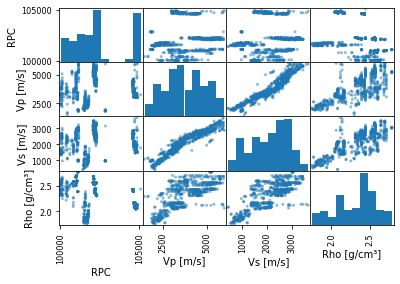

In [7]:
_ = pd.plotting.scatter_matrix(df)

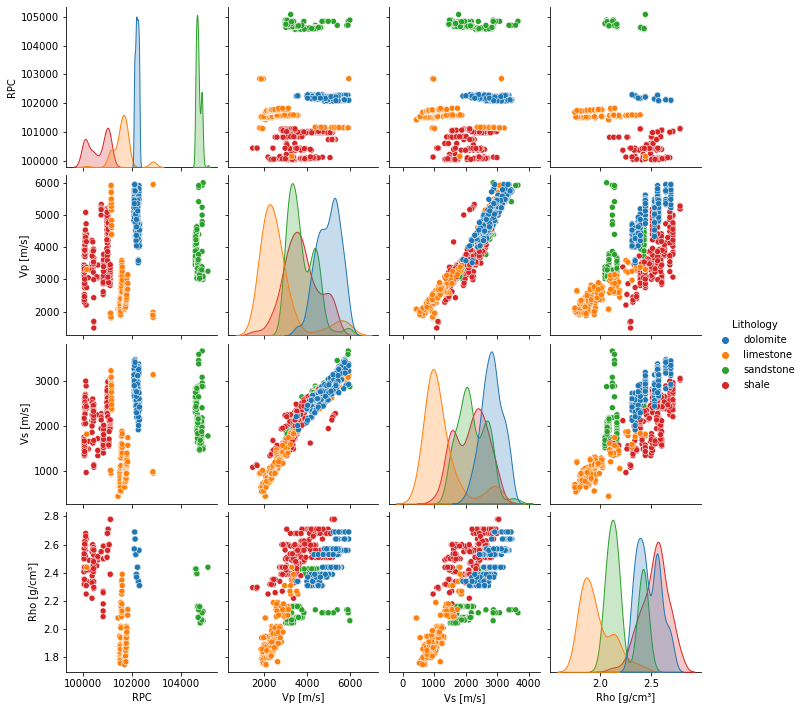

In [8]:
import seaborn as sns

sns.pairplot(df, hue='Lithology')

<AxesSubplot:xlabel='Vp [m/s]', ylabel='Rho [g/cm³]'>

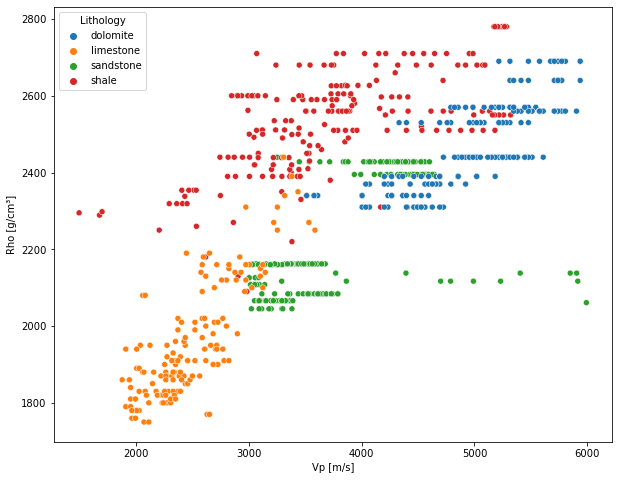

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), facecolor='w')
sns.scatterplot(x=df['Vp [m/s]'], y=1000*df['Rho [g/cm³]'], hue=df['Lithology'])

---

## Predict `Vs` from Vp

While we get used to the idea of regression, let's start with something fairly straightforward: predicting one thing from one other thing. In ML-speak, this is a **univariate** or one-dimensional problem, because an input to the model will have only 1 feature or 'dimension'.

We'll predict Vs from Vp, because that's a really common thing to want to do.

💡 Note that there's a bit of a divergence between how we talk about dimensions in NumPy and how we talk about them with respect to machine learning and datasets.

In NumPy, we say this array has one dimension:

    array([0.30, 0.25, 0.15, 0.42, 0.10])
    
But in data science we often see a row of data like this as a single row in a two-dimensional NumPy array of data like this:

    array([[0.30, 0.25, 0.15, 0.42, 0.10],
           [0.34, 0.20, 0.22, 0.40, 0.16],
           [0.32, 0.19, 0.35, 0.52, 0.08]])  # This dataset contains 3 records, each with 5 features.
           
In this case, each row is a **feature vector**. You can think of vectors as locations in n-dimensional space, in other words, 'coordinates'. So we can represent a vector like (3, 4) as a point on the Cartesian plane, and one like (3, 4, 5) as a point in 3D space. Likewise, our five-element feature vector can be represented as a point in 5-dimensional space.

So you might hear someone describe this 2-dimensional NumPy array as 5-dimensional data. It's confusing.

Many machine learning methods are easier to understand with this kind of geometric interpretation of data.

### Make `X` and `y`

We call the inputs `X` (usually this is a matrix, i.e. a 2D array), and the output `y` (usually a vector, i.e. a 1D array).

### EXERCISE

- Assign the **Vp** column to `X` and the **Vs** column to `y`. Use `pd.Series.values` to get the data as NumPy arrays. These are easier to manipulate than Pandas objects.
- Reshape `X`, which has shape (800,), to ensure that it has 2 dimensions (in the NumPy sense). That is, convert it into a 'column vector' with shape (800, 1).
- Plot `y` against `X`.

In [10]:
# YOUR CODE HERE



In [11]:
X = df['Vp [m/s]'].values
y = df['Vs [m/s]'].values

X.shape

(800,)

In [12]:
X = X.reshape(-1, 1)

X.shape

(800, 1)

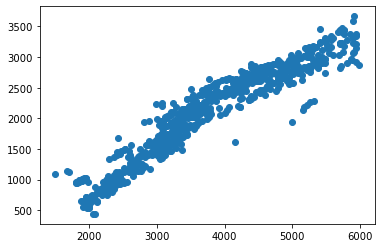

In [13]:
plt.scatter(X, y)

## Train a model

We're going to fit a simple linear model of the form:

$$ \hat{y} = w x^1 + b $$

where $w$ is the so-called **coefficient** or **gradient** or **weight** and `b` is the **intercept** or **bias** term. We can also collectively refer to `a` and `b` as the **parameters** (or even 'weights' or 'coefficients').

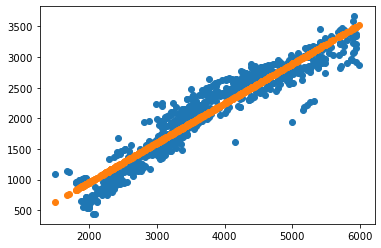

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

y_pred = model.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_pred)

We can look at the parameters:

In [15]:
model.coef_

array([0.64261339])

In [16]:
model.intercept_

-327.45685506223026

Let's represent the model as a line on the plot:

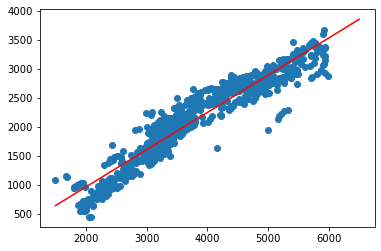

In [17]:
# Draw an arbitrary line for the best fit:
import numpy as np

X_syn = np.linspace(1500, 6500).reshape(-1, 1)
y_syn = model.predict(X_syn)

plt.scatter(X, y)
plt.plot(X_syn, y_syn, c='red')

## ❓What do we think of this?

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

Issues:

- Need more than a qualitative evaluation: use metrics.
- We're evaluating with the training data: use validation.
- The model does not look complex enough: there's a bend in the data.

## Evaluation

We need a quantiative way to tell how we are doing.

Two common metrics for linear regression problems are:

- R<sup>2</sup>, ['coeffiecient of determination'](https://en.wikipedia.org/wiki/Coefficient_of_determination) or 'explained variance'. 
- RMSE, or [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation). 

Along with these metrics, it's essential to inspect the residuals to ensure that they are:

- Approximately normally distributed.
- Not correlated with the inputs or output.
- [Homoskedastic](https://en.wikipedia.org/wiki/Heteroscedasticity) (the variance is not correlated with inputs or output).

These conditions are assumptions of Gauss&ndash;Markov theorem, which underlies linear regression.

### EXERCISE

Write a function to compute RMSE given true target $y$ and predicted values $\hat{y}$.

If you like seeing symbolic maths, the equation looks like this:

$$ \operatorname{RMSE}=\sqrt{\frac{\sum_{i=1}^N (\hat{y}_i - y_i)^2}{N}} $$

If you prefer, you can get some of the way there with `sklearn`'s [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function.

In [18]:
# YOUR CODE HERE



In [19]:
from sklearn.metrics import r2_score, mean_squared_error
from collections import namedtuple
import numpy as np

def rmse_score(y_true, y_predicted):
    """
    Example
        >>> rmse_score([1, 14], [5, 10])
        4.0
    """
    y_true, y_predicted = np.asarray(y_true), np.asarray(y_predicted)
    return np.sqrt(np.mean((y_true - y_predicted)**2))

def score(y_true, y_predicted):
    """
    Return the R2 and RMSE scores for a regression.
    
    Args:
        y_true (array): The true values, e.g. y_val or y_test.
        y_predicted (array): The predicted values.
        
    Returns:
        tuple: The R2 score and the RMSE.
        
    Example:
        >>> score([0.5, 1.5, 2.5], [0.5, 1.5, 2.5])
        Score(R2=1.0, RMSE=0.0)
        >>> score([0.5, 1.5, 2.5], [0.4, 1.5, 2.6])
        Score(R2=0.99, RMSE=0.08164965809277262)
    """
    r2 = r2_score(y_true, y_predicted)
    rmse = rmse_score(y_true, y_predicted)
    
    result = namedtuple('Score', ['R2', 'RMSE'])
    
    return result(r2, rmse)

In [20]:
import doctest

doctest.testmod(verbose=True)

Trying:
    rmse_score([1, 14], [5, 10])
Expecting:
    4.0
ok
Trying:
    score([0.5, 1.5, 2.5], [0.5, 1.5, 2.5])
Expecting:
    Score(R2=1.0, RMSE=0.0)
ok
Trying:
    score([0.5, 1.5, 2.5], [0.4, 1.5, 2.6])
Expecting:
    Score(R2=0.99, RMSE=0.08164965809277262)
ok
1 items had no tests:
    __main__
2 items passed all tests:
   1 tests in __main__.rmse_score
   2 tests in __main__.score
3 tests in 3 items.
3 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=3)

### `X` as an augmented matrix

Let's imagine we have an expression like:

$$ \hat{y} = w_1 x^1 + w_0 x^0 $$

In [21]:
X_ = np.vstack([X.flat, np.ones(X.size)]).T
X_[:5]

array([[3.0456e+03, 1.0000e+00],
       [3.0006e+03, 1.0000e+00],
       [3.3636e+03, 1.0000e+00],
       [3.1953e+03, 1.0000e+00],
       [4.2375e+03, 1.0000e+00]])

In [22]:
model = LinearRegression(fit_intercept=False)  # <-- important.

model.fit(X_, y, )

model.coef_, model.intercept_

(array([   0.64261339, -327.45685506]), 0.0)

---

## Validation

We don't really know how this model performs, because we've validated it with the training data.

We need to split the dataset into at least 2 pieces, maybe more. There are various strategies we could use, but let's keep it simple and split into two: **training** and **validation**.

### EXERCISE

Use [`sklearn.model_selection.train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split each of `X` and `y` into two pieces. You can call it like this:

    X_train, X_val, y_train, y_val = train_test_split(X, y)
    
Add arguments to get a test proprtion of 20% and use a random seed of 42.

In [23]:
# YOUR CODE HERE



In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_val.shape

((640, 1), (160, 1))

### EXERCISE

Retrain the model **using the training data only** and then get a score **using the validation data only**.

You code should look like, replacing the 🐍🐍🐍 with Python code:

```
model = LinearRegression()
model.fit( 🐍🐍🐍, 🐍🐍🐍 )
🐍🐍🐍 = model.predict( 🐍🐍🐍 )
score( 🐍🐍🐍, 🐍🐍🐍 )
```

In [26]:
# YOUR CODE HERE



In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
score(y_val, y_pred)

Score(R2=0.9128160415665872, RMSE=219.59798073828102)

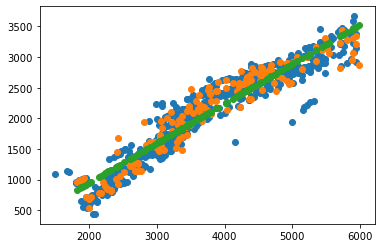

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)
plt.scatter(X_val, y_pred)

## Add interactions and/or polynomial features

We also need to deal with that bend in the middle of the data.

The good news is that linear algorithms can actually model nonlinear relationships! For example, although this relationship is not linear with respect to x, this model is linear respect to the parameters:

$$ \hat{y} = w_2 x^2 + w_1 x + b $$

Note that this is not called "nonlinear regression", which involves optimizing parameters in expressions like $\hat{y} = a \mathrm{e}^{bx}$, but is sometimes called **polynomial regression**. Transforming `X` in this way is sometimes called **basis expansion** ([read more](http://madrury.github.io/jekyll/update/statistics/2017/08/04/basis-expansions.html)).

Adding polynomial relationships is really a generalization of adding **feature interactions**. For example, if I have features $x_1$ and $x_2$, I can add $x_1 x_2$. The full 2nd degree polynomial expansion then looks like this:

$$ \hat{y} = w_5 x_1^2 + w_4 x_2^2 + w_3 x_1 x_2 + w_2 x_1 + w_1 x_2 + b $$

So instead of having just two features and fitting three parameters, I have five features and six parameters. This allows me to make a more complex model that can capture more variance in the data. But complexity always comes with the risk of overfitting!

The way to add these new features is with `sklearn.preprocessing.PolynomialFeatures()` (specifying the degree and whether you only want interactions, or polynomial features as well). And the easiest way to include this step is in an `sklearn.pipline.Pipeline`:

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

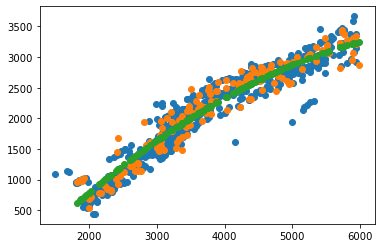

In [30]:
plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)
plt.scatter(X_val, y_pred)

In [31]:
score(y_val, y_pred)

Score(R2=0.9347069281920044, RMSE=190.0393783689433)

## Add another feature

We still have lots of ways in which we can improve this model.

We know that `Vs` is related to `Vp`, but know it is also related to density, `rho`. So we should be able to get a better fit by adding that feature.

In [32]:
features = ['Vp [m/s]', 'Rho [g/cm³]']

df_ = df.dropna()  # <-- Important.

X = df_[features].values
y = df_['Vs [m/s]'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

We're going to return to the simpler case for a moment, without the basis expansion.

In [33]:
model = LinearRegression()  # Simpler model.
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
score(y_val, y_pred)

Score(R2=0.9194567121320073, RMSE=211.38122066457288)

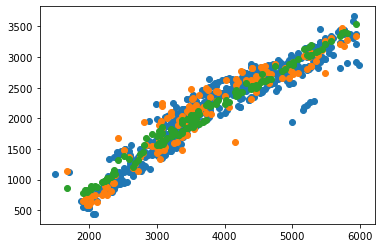

In [34]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_val[:, 0], y_val)
plt.scatter(X_val[:, 0], y_pred)

In [35]:
model.coef_, model.intercept_

(array([  0.58438847, 441.75389082]), -1126.2337194651882)

‼️ Notice that one coefficient is very large compared to the other. We cannot interpret the coefficients as 'importance', because the input features have completely different scales.

## Scaling

The problem is that one of the features has much smaller values than the other one, so the coefficients are not very interesting — they just reflect the arbitrary units of the inputs.

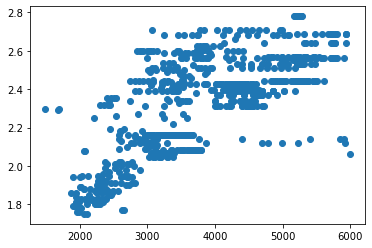

In [36]:
plt.scatter(*X.T)

In general, we need to be able to compare all sorts of different properties, with disparate units like currency, length, mass, speed, or radioactivity levels. In fact, the model only really cares about the **distributions** of our properties, so we can transform them to make them more comparable. 

A common way to do this is with Z-score, also known as **standardization**.

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [38]:
X_train_scaled[:5]

array([[-0.22758182,  0.08280557],
       [ 0.39271175,  0.29957427],
       [-0.48068463, -0.92615417],
       [-0.72728393, -0.61873675],
       [-1.38015225, -1.80899394]])

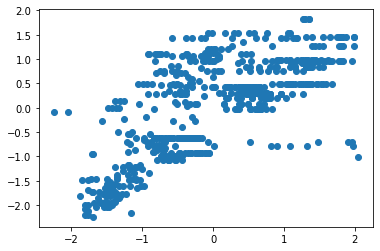

In [39]:
plt.scatter(*X_train_scaled.T)

But there are some catches:

- It makes like a bit more complicated, because now we have to scale everything that goes into the model, during training, during validation, and later during application.
- We have to be careful not to try to scale the dataset with knowledge of validation or test data. The scaling can only know about the training data.
- Non-Gaussian distributions should probably not be standardized, but should instead be **normalized** (e.g. squeezed into a range like 0 to 1 or –1 to +1.

Luckily there are tools in `sklearn` for all this. We can take care of the first two issues with `pipelines`.

In [40]:
model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

This usually does not improve the model:

In [41]:
score(y_val, y_pred)

Score(R2=0.9194567121320074, RMSE=211.38122066457277)

But now the coefficients are interpretable:

In [42]:
m = model.named_steps['linearregression']

m.coef_, m.intercept_

(array([612.82759442, 112.08474575]), 2146.668800196341)

## Add regularization

If overfitting becomes an issue, we can add **regularization**. Applying L2 regularization requires the `Ridge` algorithm; applying L1 regularization requires the `Lasso` algorithm (or you can combine them with `ElasticNet`).

Regularization adds a constraint to the model parameters, preventing them from getting too large. This has the effect of 'smoothing' the model, making it less complex and therefore less able to overfit to the training data.

Many algorithms in machine learning use regularization of one kind or another, or have other hyperparameters that have essentially the same effect. The idea is always to somehow prevent the model from becoming too complex.

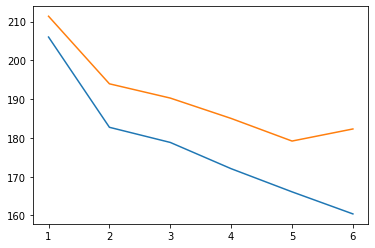

In [46]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline

train_scores, val_scores = [], []
for d in (degree := range(1, 7)):  # <-- Change to 1, 11 for Ridge()

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('expansion', PolynomialFeatures(degree=d)),
        ('regressor', LinearRegression()),  # <-- Change to Ridge()
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    r2, rmse = score(y_val, y_pred)
    val_scores.append(rmse)
    
    r2, rmse = score(y_train, model.predict(X_train))
    train_scores.append(rmse)
    
plt.plot(degree, train_scores)
plt.plot(degree, val_scores)

In [47]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('scaler', StandardScaler()),
    ('expansion', PolynomialFeatures(degree=6)),
    ('regressor', Ridge()),
])

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

score(y_val, y_pred)

Score(R2=0.9440308636141167, RMSE=176.2081645092391)

In [48]:
model.named_steps['regressor'].coef_

array([   0.        ,  632.84484485,   50.66545494, -393.35187963,
         50.30544142,  -10.4540931 ,  -14.41176711, -160.20120048,
        268.6575981 ,  -67.13409159,  212.98992057, -118.9404889 ,
         24.88779261,   18.58364305,    9.6816681 ,    6.46873808,
         87.12906899, -148.59156192,   59.89383181,   14.30401257,
        -17.73588708,  -21.57270994,  -14.14139365,  -51.67623011,
         85.98472554,   84.32168519, -139.95625539,   37.90830427])

## Predict density

We actually don't need a prediction of Vs right now, because we already know it. But we have some missing values in the density column. Let's try to replace them.

In [49]:
features = ['Vp [m/s]', 'Vs [m/s]']

nulls = df['Rho [g/cm³]'].isnull()

X = df.loc[~nulls, features].values
y = df.loc[~nulls, 'Rho [g/cm³]'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('expansion', PolynomialFeatures(degree=3)),
    ('regressor', Ridge(alpha=3)),
])

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

score(y_val, y_pred)

Score(R2=0.6659253000553724, RMSE=0.15149936705782333)

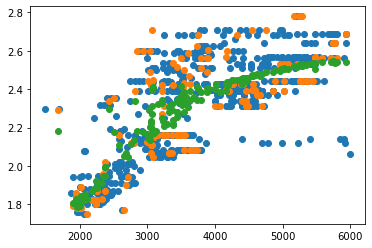

In [51]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_val[:, 0], y_val)
plt.scatter(X_val[:, 0], y_pred)

## ❓ What do we think of this?

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<AxesSubplot:xlabel='Vp [m/s]', ylabel='Rho [g/cm³]'>

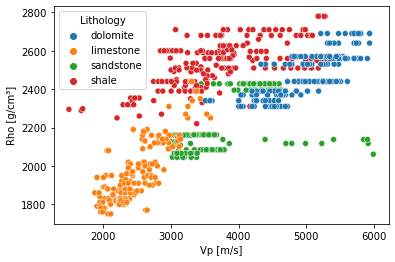

In [52]:
sns.scatterplot(x=df['Vp [m/s]'], y=1000*df['Rho [g/cm³]'], hue=df['Lithology'])

## Take lithology into account

What if we make lithology into a feature? That seems like it should help.

In [53]:
features = ['Vp [m/s]', 'Vs [m/s]', 'Lithology']

nulls = df['Rho [g/cm³]'].isnull()

X = df.loc[~nulls, features].values
y = df.loc[~nulls, 'Rho [g/cm³]'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

tx = ColumnTransformer([
    ('scaler', StandardScaler(), [0, 1]),
    ('ohe', OneHotEncoder(drop='first'), [2]) # Drop = first ensures they do not add to 1 (like the intercept)
])

model = Pipeline([
    ('transform', tx),
    ('expansion', PolynomialFeatures(degree=3)),
    ('regressor', Ridge(alpha=3)),
])

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

score(y_val, y_pred)

Score(R2=0.913825104549134, RMSE=0.07694482345227704)

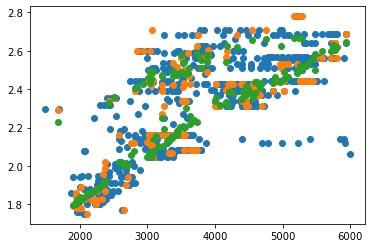

In [55]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_val[:, 0], y_val)
plt.scatter(X_val[:, 0], y_pred)

That's much better!

## Finalize the prediction

In [56]:
model.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  [0, 1]),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  [2])])),
                ('expansion', PolynomialFeatures(degree=3)),
                ('regressor', Ridge(alpha=3))])

In [57]:
X_new = df.loc[nulls, features].values

y_pred = model.predict(X_new)

In [58]:
y_pred

array([1.79292621, 1.81099588, 2.78102917, 1.80579032, 1.79744247,
       2.76576303, 2.78314789, 2.73705727, 1.81680495, 1.82655321,
       1.82046877, 2.76629986, 1.80367053, 1.80719968, 2.67898577,
       1.81246411, 1.81878254, 2.72717144, 1.80154378, 2.76515889,
       1.78221155, 2.76184231, 2.71283774, 2.63884167, 2.70732526,
       1.78227188, 2.7857235 , 2.55429277, 1.82267984, 1.80964968,
       1.80747921, 2.72754643, 1.81393647, 1.80383558, 2.74037406,
       2.57860297, 2.74106056, 1.80247717, 1.7794031 , 2.78204466,
       1.82413097, 2.60595051, 1.80128474, 1.78558136, 1.80565071,
       2.78296621, 1.78883829, 1.82413097])

In [59]:
df.loc[nulls, 'Rho [g/cm³]'] = y_pred
df['pred'] = 0
df.loc[nulls, 'pred'] = 1

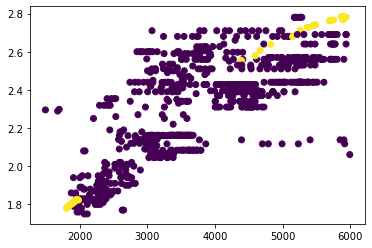

In [60]:
plt.scatter(df['Vp [m/s]'], df['Rho [g/cm³]'], c=df['pred'])

In [62]:
df.to_csv('/local/S3/geocomp/data/RPC_4_lithologies_imputed.csv', index=False)

---

&copy; 2022 Agile Scientific